In [9]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

## Read Data

In [10]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,22) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

574  images are above our threshold and thus removed from the list


### Load the Saved Autoencoder Model

In [11]:
# Generate and Compile a Deep Autoencoder
img_size = height*width
autoencoder = compile_autoencoder(imgs, img_size)

# Load the saved model
autoencoder = load_model('model_autoencoder.h5')
# encoder = load_model('model_encoder.h5')

### Visualize the Reconstructed Image

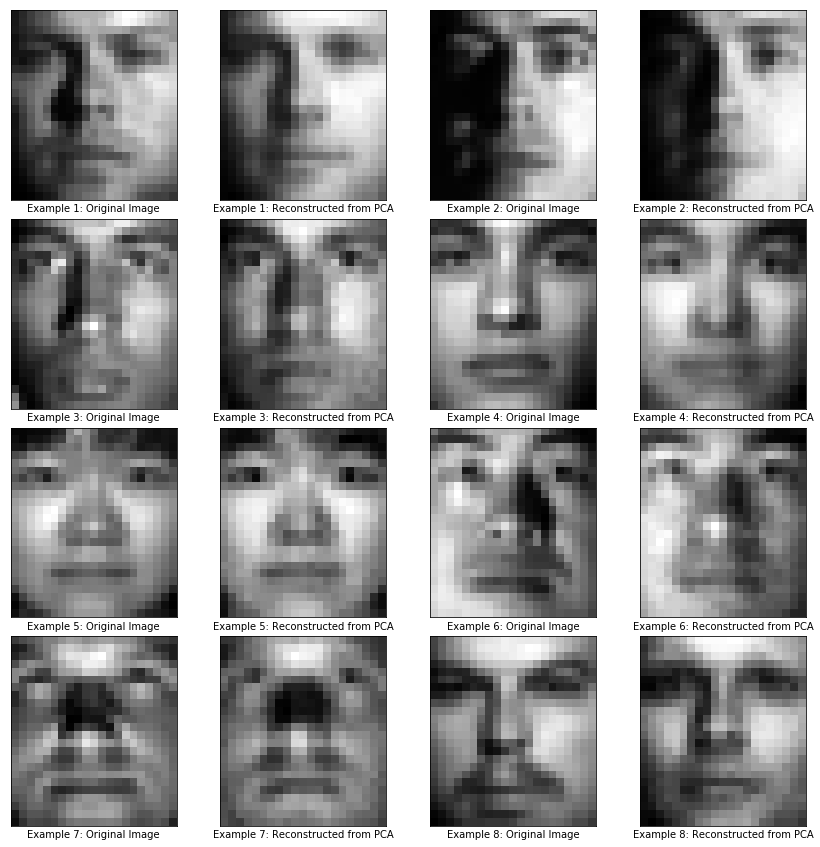

In [30]:
imgs_trans = np.transpose(imgs) # Transpose
imgs_trans = imgs_trans.astype('float32') / 255. # Resize
# Load into the model and get the processed output
imgs_reconst = autoencoder.predict(imgs_trans)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(np.transpose(imgs_reconst),imgs,height,width)

## Anomaly Detection with Reconstruction Error

In [33]:
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = split_train_eval_test(labels)
x_all = np.transpose(imgs)
x_train = x_all[train_ind,:]
x_test = x_all[test_ind,:]
labels_train = labels[train_ind]
labels_test = labels[test_ind]

# Normalize the Data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist = find_euclidean_distance(img_matrix_reconst_all,imgs_matrix)
np.min(dist),np.mean(dist),np.max(dist)